
# 1. Introduction

**Name:** Muhammad Erico Ricardo
**Project Title:** Used Car Price Regression

In this project, I built a machine learning model to **predict used car prices** using **345 data samples** collected from **OLX (Jakarta region only)** through web scraping. The dataset includes cars with **various brands and types**, making it diverse and challenging.

I compared the performance of five different regression algorithms:

* **Linear Regression**
* **Support Vector Regression (SVR)**
* **Ridge Regression**
* **Decision Tree Regressor**
* **XGBoost**

If you’re interested in the web scraping process, you can check out the code in the **`Car_Web_Scrapping_olx.ipynb`** notebook.


# 2. Import Libraries


In [2]:
!pip install phik
!pip install feature_engine

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import numpy as np
import pandas as pd
import pickle
import json
import warnings


from phik import phik
from feature_engine.outliers import Winsorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.exceptions import FitFailedWarning
import xgboost as xgb

# 3. Data Loading

## 3.1 Quick Data Overview


In [4]:
# Read data from csv
data = pd.read_csv("olx_scrape.csv")
# Display the first few rows of the dataframa
data.head()

,Title,Fuel,Price,Engine,Location,Transmission,Range,Description
0,toyota rush (2022),Bensin,Rp 219.000.000,>1.000 - 1.500 cc,"Cilandak, Jakarta Selatan",Automatic,40.000-45.000 Km,"Deskripsi ""Toyota Rush 1.5 S GR Sport Bensin-A..."
1,daihatsu xenia (2021),Bensin,Rp 168.000.000,>1.000 - 1.500 cc,"Cilandak, Jakarta Selatan",Automatic,85.000-90.000 Km,"Deskripsi ""Daihatsu Xenia 1.3 . Khusus Harga K..."
2,toyota raize (2023),Bensin,Rp 212.000.000,<1.000 cc,"Cilandak, Jakarta Selatan",Automatic,35.000-40.000 Km,"Deskripsi ""Toyota Raize 1.0 . Khusus Harga Kre..."
3,honda brio satya (2019),Bensin,Rp 149.000.000,>1.000 - 1.500 cc,"Cilandak, Jakarta Selatan",Automatic,65.000-70.000 Km,"Deskripsi ""Honda Brio Satya 1.2 E Bensin-AT 20..."
4,hyundai stargazer (2024),Bensin,Rp 239.000.000,>1.000 - 1.500 cc,"Mampang Prapatan, Jakarta Selatan",Automatic,0-5.000 Km,Deskripsi [ B GENAP DZL ] Hyundai Stargazer Pr...


In [5]:
# See the columns in dataframe
data.columns

Index(['Title', 'Fuel', 'Price', 'Engine', 'Location', 'Transmission', 'Range',
       'Description'],
      dtype='object')

We can see that in dataframe has 8 column, which is :
1. Title, title of the ads
2. Fuel, Fuel type of the car can be contain Bensin(Petrol)/Diesel
3. Price, price of the car in ads
4. Engine, Range of cylinder engine capasity
5. Location, Location of the ads
6. Transmission, Transmission of the car (Matic/Manual)
7. Range, range car millage in Kilometer
8. Description of the car

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 345 entries, 0 to 344
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Title         345 non-null    object
 1   Fuel          345 non-null    object
 2   Price         345 non-null    object
 3   Engine        345 non-null    object
 4   Location      345 non-null    object
 5   Transmission  345 non-null    object
 6   Range         345 non-null    object
 7   Description   345 non-null    object
dtypes: object(8)
memory usage: 21.7+ KB


In [7]:
data.describe()

,Title,Fuel,Price,Engine,Location,Transmission,Range,Description
count,345,345,345,345,345,345,345,345
unique,270,5,218,8,12,4,45,329
top,toyota kijang innova (2023),Bensin,Rp 250.000.000,>1.000 - 1.500 cc,"Cilandak, Jakarta Selatan",Automatic,20.000-25.000 Km,Deskripsi NISSAN LEAF EV HATCHBACK TWO TONE Ta...
freq,10,282,7,107,151,296,33,3


## 3.2 Data Transforming
There is few data that we can transform from one column to another new column


In [8]:
# Create Year column that take year from title column
data['Year'] = data['Title'].str.extract(r'(\b20\d{2}\b|\b19\d{2}\b)')
# Delete year from title column
data['Title'] = data['Title'].str.replace(
    r'\(?\b(19\d{2}|20\d{2})\b\)?', '', regex=True
).str.replace(r'\s+', ' ', regex=True).str.strip()

data.head()

,Title,Fuel,Price,Engine,Location,Transmission,Range,Description,Year
0,toyota rush,Bensin,Rp 219.000.000,>1.000 - 1.500 cc,"Cilandak, Jakarta Selatan",Automatic,40.000-45.000 Km,"Deskripsi ""Toyota Rush 1.5 S GR Sport Bensin-A...",2022
1,daihatsu xenia,Bensin,Rp 168.000.000,>1.000 - 1.500 cc,"Cilandak, Jakarta Selatan",Automatic,85.000-90.000 Km,"Deskripsi ""Daihatsu Xenia 1.3 . Khusus Harga K...",2021
2,toyota raize,Bensin,Rp 212.000.000,<1.000 cc,"Cilandak, Jakarta Selatan",Automatic,35.000-40.000 Km,"Deskripsi ""Toyota Raize 1.0 . Khusus Harga Kre...",2023
3,honda brio satya,Bensin,Rp 149.000.000,>1.000 - 1.500 cc,"Cilandak, Jakarta Selatan",Automatic,65.000-70.000 Km,"Deskripsi ""Honda Brio Satya 1.2 E Bensin-AT 20...",2019
4,hyundai stargazer,Bensin,Rp 239.000.000,>1.000 - 1.500 cc,"Mampang Prapatan, Jakarta Selatan",Automatic,0-5.000 Km,Deskripsi [ B GENAP DZL ] Hyundai Stargazer Pr...,2024


In [9]:
# Create Brand Column from the title
# take the brand name from the title column
data['Brand'] = data['Title'].str.split().str[0]
# cut the brand name from the title column
data['Title'] = data['Title'].str.replace(r'^\w+\s+', '', regex=True)
data.head()

,Title,Fuel,Price,Engine,Location,Transmission,Range,Description,Year,Brand
0,rush,Bensin,Rp 219.000.000,>1.000 - 1.500 cc,"Cilandak, Jakarta Selatan",Automatic,40.000-45.000 Km,"Deskripsi ""Toyota Rush 1.5 S GR Sport Bensin-A...",2022,toyota
1,xenia,Bensin,Rp 168.000.000,>1.000 - 1.500 cc,"Cilandak, Jakarta Selatan",Automatic,85.000-90.000 Km,"Deskripsi ""Daihatsu Xenia 1.3 . Khusus Harga K...",2021,daihatsu
2,raize,Bensin,Rp 212.000.000,<1.000 cc,"Cilandak, Jakarta Selatan",Automatic,35.000-40.000 Km,"Deskripsi ""Toyota Raize 1.0 . Khusus Harga Kre...",2023,toyota
3,brio satya,Bensin,Rp 149.000.000,>1.000 - 1.500 cc,"Cilandak, Jakarta Selatan",Automatic,65.000-70.000 Km,"Deskripsi ""Honda Brio Satya 1.2 E Bensin-AT 20...",2019,honda
4,stargazer,Bensin,Rp 239.000.000,>1.000 - 1.500 cc,"Mampang Prapatan, Jakarta Selatan",Automatic,0-5.000 Km,Deskripsi [ B GENAP DZL ] Hyundai Stargazer Pr...,2024,hyundai


In [10]:
# change column name from "title" to "type"
data.rename(columns={'Title': 'Type'}, inplace=True)
data.head()

,Type,Fuel,Price,Engine,Location,Transmission,Range,Description,Year,Brand
0,rush,Bensin,Rp 219.000.000,>1.000 - 1.500 cc,"Cilandak, Jakarta Selatan",Automatic,40.000-45.000 Km,"Deskripsi ""Toyota Rush 1.5 S GR Sport Bensin-A...",2022,toyota
1,xenia,Bensin,Rp 168.000.000,>1.000 - 1.500 cc,"Cilandak, Jakarta Selatan",Automatic,85.000-90.000 Km,"Deskripsi ""Daihatsu Xenia 1.3 . Khusus Harga K...",2021,daihatsu
2,raize,Bensin,Rp 212.000.000,<1.000 cc,"Cilandak, Jakarta Selatan",Automatic,35.000-40.000 Km,"Deskripsi ""Toyota Raize 1.0 . Khusus Harga Kre...",2023,toyota
3,brio satya,Bensin,Rp 149.000.000,>1.000 - 1.500 cc,"Cilandak, Jakarta Selatan",Automatic,65.000-70.000 Km,"Deskripsi ""Honda Brio Satya 1.2 E Bensin-AT 20...",2019,honda
4,stargazer,Bensin,Rp 239.000.000,>1.000 - 1.500 cc,"Mampang Prapatan, Jakarta Selatan",Automatic,0-5.000 Km,Deskripsi [ B GENAP DZL ] Hyundai Stargazer Pr...,2024,hyundai


In [11]:
# Delete "Rp" from price and change type tu integer
data['Price'] = (
    data['Price']
    .str.replace(r'\D', '', regex=True)
    .astype('Int64')  # biar bisa menampung lebih besar daripada int default
)
data.head()

,Type,Fuel,Price,Engine,Location,Transmission,Range,Description,Year,Brand
0,rush,Bensin,219000000,>1.000 - 1.500 cc,"Cilandak, Jakarta Selatan",Automatic,40.000-45.000 Km,"Deskripsi ""Toyota Rush 1.5 S GR Sport Bensin-A...",2022,toyota
1,xenia,Bensin,168000000,>1.000 - 1.500 cc,"Cilandak, Jakarta Selatan",Automatic,85.000-90.000 Km,"Deskripsi ""Daihatsu Xenia 1.3 . Khusus Harga K...",2021,daihatsu
2,raize,Bensin,212000000,<1.000 cc,"Cilandak, Jakarta Selatan",Automatic,35.000-40.000 Km,"Deskripsi ""Toyota Raize 1.0 . Khusus Harga Kre...",2023,toyota
3,brio satya,Bensin,149000000,>1.000 - 1.500 cc,"Cilandak, Jakarta Selatan",Automatic,65.000-70.000 Km,"Deskripsi ""Honda Brio Satya 1.2 E Bensin-AT 20...",2019,honda
4,stargazer,Bensin,239000000,>1.000 - 1.500 cc,"Mampang Prapatan, Jakarta Selatan",Automatic,0-5.000 Km,Deskripsi [ B GENAP DZL ] Hyundai Stargazer Pr...,2024,hyundai


In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 345 entries, 0 to 344
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Type          345 non-null    object
 1   Fuel          345 non-null    object
 2   Price         345 non-null    Int64 
 3   Engine        345 non-null    object
 4   Location      345 non-null    object
 5   Transmission  345 non-null    object
 6   Range         345 non-null    object
 7   Description   345 non-null    object
 8   Year          345 non-null    object
 9   Brand         345 non-null    object
dtypes: Int64(1), object(9)
memory usage: 27.4+ KB


In [13]:
# Change year column type to integer
data['Year'] = data['Year'].astype('Int64')

# 4. Exploratory Data Analysis

## 4.1 what brand is the most in the data

C:\Users\muham\AppData\Local\Temp\ipykernel_22800\2274974055.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=brand_counts.index, y=brand_counts.values, palette='viridis')


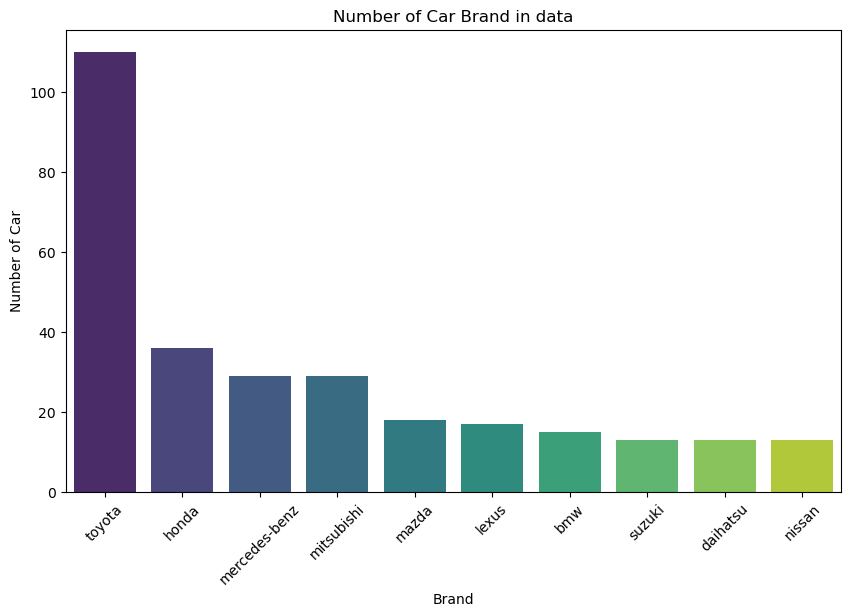

In [14]:
# create bar chart to know what brand is the most in data top 10
plt.figure(figsize=(10, 6))
brand_counts = data['Brand'].value_counts().head(10)
sns.barplot(x=brand_counts.index, y=brand_counts.values, palette='viridis')
plt.title('Number of Car Brand in data')
plt.xlabel('Brand')
plt.ylabel('Number of Car')
plt.xticks(rotation=45)
plt.show()

### **1. Car Brands Distribution**

* **Toyota** overwhelmingly dominates the dataset with more than **110 cars**, far ahead of other brands.
* The next most common brands are **Honda, Mercedes-Benz, and Mitsubishi** (around 30 cars each).
* Other brands such as Mazda, Lexus, BMW, Nissan, Suzuki, and Daihatsu appear less frequently (<20 cars each).
* This confirms Toyota’s strong dominance in the Indonesian used car market.


## 4.2 What type is the most in the data

C:\Users\muham\AppData\Local\Temp\ipykernel_22800\1101486408.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=brand_counts.index, y=brand_counts.values, palette='viridis')


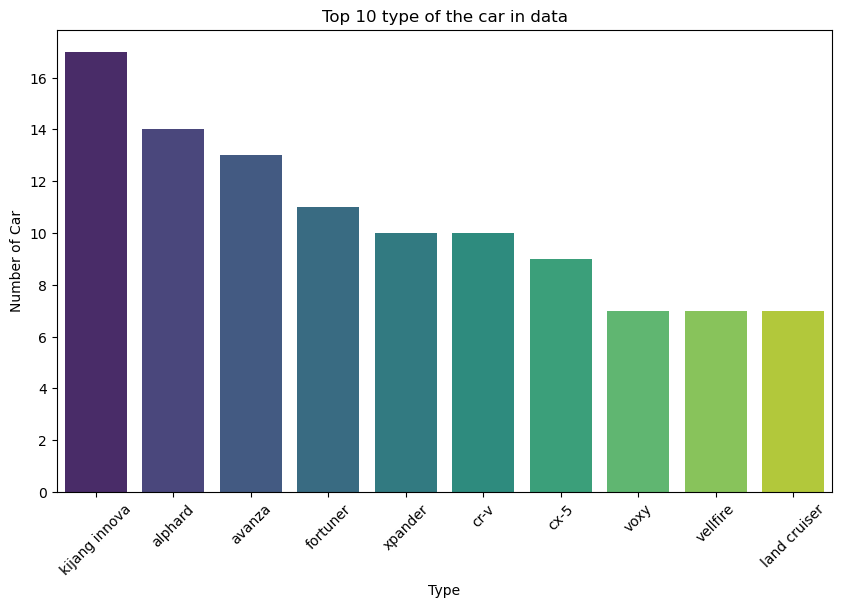

In [15]:
# create bar chart to know what type is the most in data top 10
plt.figure(figsize=(10, 6))
brand_counts = data['Type'].value_counts().head(10)
sns.barplot(x=brand_counts.index, y=brand_counts.values, palette='viridis')
plt.title('Top 10 type of the car in data')
plt.xlabel('Type')
plt.ylabel('Number of Car')
plt.xticks(rotation=45)
plt.show()

### **2. Top Car Types**

* The most common car types are mostly Toyota models:

  * **Kijang Innova (17 cars)**, **Alphard (14 cars)**, **Avanza (13 cars)**, and **Fortuner (11 cars)**.
* Other popular models include **Xpander (10)**, **CR-V (10)**, **CX-5 (9)**, **Land Cruiser (7)**, **Vellfire (7)**, and **Voxy (7)**.
* Toyota clearly dominates not only in brand but also across multiple popular models.

## 4.3 Percentage of the transmission

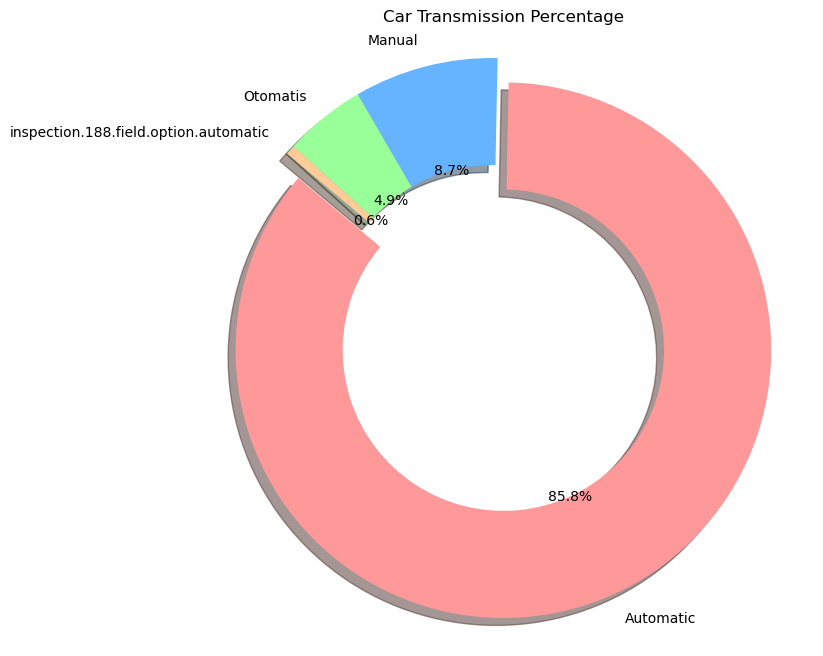

In [16]:
# hitung value counts
counts = data['Transmission'].value_counts()

# bikin explode: kategori pertama meledak, lainnya 0
explode = [0.1] + [0]*(len(counts)-1)

plt.figure(figsize=(8, 8))
colors = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99']  # tambah warna jika lebih dari 2 kategori

plt.pie(
    counts,
    labels=counts.index,
    colors=colors[:len(counts)],  # ambil sesuai jumlah kategori
    explode=explode,
    autopct='%1.1f%%',
    shadow=True,
    startangle=140,
    wedgeprops=dict(width=0.4)  # bikin jadi donut
)

plt.title('Car Transmission Percentage')
plt.axis('equal')
plt.show()


### **3. Transmission Type**

* The market is **heavily skewed towards Automatic transmissions (85.8%)**.
* Manual cars represent only **8.7%**.
* Minor inconsistencies in scraping created categories like *“Otomatis”* and *“inspection.188.field.option.automatic”*, but their proportions are negligible.
* Insight: Indonesian used car buyers strongly prefer **automatic cars**.


## 4.4 Percentage of Fuel

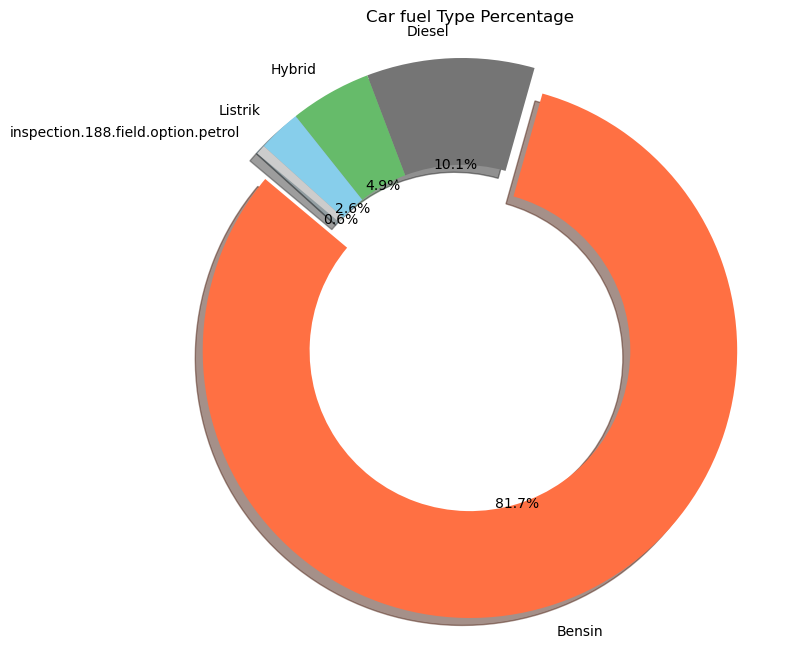

In [17]:
import matplotlib.pyplot as plt

# hitung value counts
counts = data['Fuel'].value_counts()

# explode kategori pertama saja biar fokus
explode = [0.1] + [0]*(len(counts)-1) if len(counts) > 0 else []

plt.figure(figsize=(8, 8))

# warna dipilih sesuai kategori
color_map = {
    'Bensin': '#ff7043',   # orange kemerahan
    'Diesel': '#757575',   # abu-abu gelap
    'Hybrid': '#66bb6a',   # hijau segar
    'Listrik': '#87CEEB'   # biru muda
}

# gunakan .get biar aman kalau ada kategori lain
colors = [color_map.get(fuel, '#cccccc') for fuel in counts.index]

plt.pie(
    counts,
    labels=counts.index,
    colors=colors,
    explode=explode,
    autopct='%1.1f%%',
    shadow=True,
    startangle=140,
    wedgeprops=dict(width=0.4)  # donut chart
)

plt.title('Car fuel Type Percentage')
plt.axis('equal')
plt.show()


### **4. Fuel Type**

* The dataset is dominated by **Petrol (Bensin) cars at 81.7%**.
* **Diesel cars account for 10.1%**, a significant minority.
* **Hybrid (4.9%)** and **Electric (2.6%)** cars are present but remain niche in the used car market.
* Insight: The market is still very dependent on petrol, though EV and hybrid adoption is slowly emerging.

## 4.5 Distribution of the Millage of the car

In [18]:
data['Range'].unique()

array(['40.000-45.000 Km', '85.000-90.000 Km', '35.000-40.000 Km',
       '65.000-70.000 Km', '0-5.000 Km', '25.000-30.000 Km',
       '20.000-25.000 Km', '5.000-10.000 Km', '75.000-80.000 Km',
       '130.000-135.000 Km', '10.000-15.000 Km', '30.000-35.000 Km',
       '50.000-55.000 Km', '60.000-65.000 Km', '45.000-50.000 Km',
       '70.000-75.000 Km', '95.000-100.000 Km', '0 Km',
       '90.000-95.000 Km', '10000 Km', '81720 Km', '55.000-60.000 Km',
       '175.000-180.000 Km', '120.000-125.000 Km', '90000 Km',
       '>300.000 Km', '115.000-120.000 Km', '135.000-140.000 Km',
       '40000 Km', '15.000-20.000 Km', '70000 Km', '145.000-150.000 Km',
       '100.000-105.000 Km', '110.000-115.000 Km', '150.000-155.000 Km',
       '160000 Km', '50000 Km', '140000 Km', '120000 Km',
       '140.000-145.000 Km', '125.000-130.000 Km', '30000 Km',
       '80.000-85.000 Km', '105.000-110.000 Km', '74835 Km'], dtype=object)

C:\Users\muham\AppData\Local\Temp\ipykernel_22800\1425763996.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=range_counts.index, y=range_counts.values, palette="Blues")


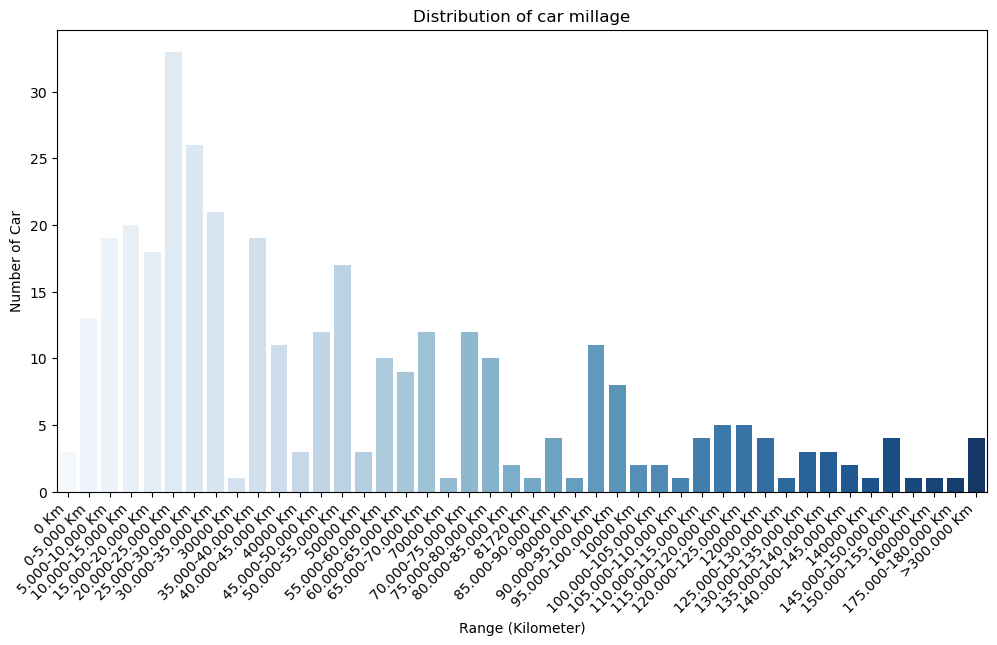

In [19]:
# urutan range yang kamu inginkan
range_order = ['0 Km','0-5.000 Km','5.000-10.000 Km','10.000-15.000 Km','15.000-20.000 Km','20.000-25.000 Km','25.000-30.000 Km','30.000-35.000 Km','30000 Km','35.000-40.000 Km','40.000-45.000 Km','40000 Km','45.000-50.000 Km','50.000-55.000 Km','50000 Km','55.000-60.000 Km','60.000-65.000 Km','65.000-70.000 Km','70000 Km','70.000-75.000 Km','75.000-80.000 Km','80.000-85.000 Km','81720 Km','85.000-90.000 Km','90000 Km','90.000-95.000 Km','95.000-100.000 Km','10000 Km','100.000-105.000 Km','105.000-110.000 Km','110.000-115.000 Km','115.000-120.000 Km','120.000-125.000 Km','120000 Km','125.000-130.000 Km','130.000-135.000 Km','135.000-140.000 Km','140.000-145.000 Km','140000 Km','145.000-150.000 Km','150.000-155.000 Km','160000 Km','175.000-180.000 Km','>300.000 Km']

# jadikan categorical
data['Range'] = pd.Categorical(data['Range'], categories=range_order, ordered=True)

# hitung jumlah
range_counts = data['Range'].value_counts().sort_index()

# plotting
plt.figure(figsize=(12,6))
sns.barplot(x=range_counts.index, y=range_counts.values, palette="Blues")
plt.title("Distribution of car millage")
plt.xlabel("Range (Kilometer)")
plt.ylabel("Number of Car")
plt.xticks(rotation=45, ha="right")
plt.show()


### **5. Mileage Distribution**

* The majority of cars fall within **20,000 – 50,000 km**, peaking around **35,000 – 40,000 km (30+ cars)**.
* Moderate mileage cars (50,000 – 100,000 km) are also well represented.
* High mileage cars (>150,000 km) exist but are relatively few, with only a handful exceeding **300,000 km**.
* Insight: The dataset is dominated by **low-to-medium mileage cars**, which are typically more attractive to buyers.

## 4.6 Distribution of the year of the car

C:\Users\muham\AppData\Local\Temp\ipykernel_22800\343887873.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=year_counts.index, y=year_counts.values, palette="Blues")


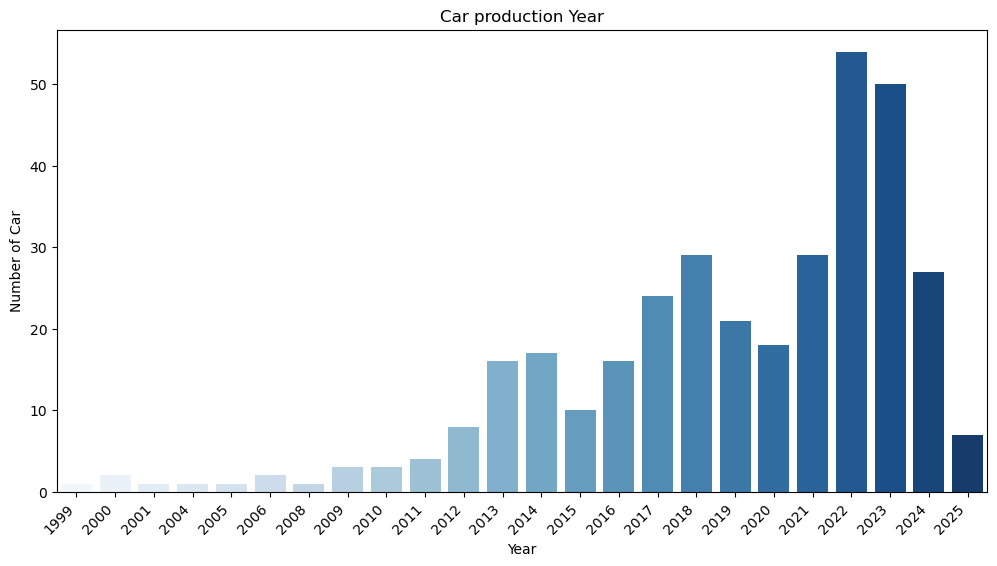

In [20]:
# Create chart to knos distribution year of the car
year_counts = data['Year'].value_counts().sort_index()
plt.figure(figsize=(12,6))
sns.barplot(x=year_counts.index, y=year_counts.values, palette="Blues")
plt.title("Car production Year")
plt.xlabel("Year")
plt.ylabel("Number of Car")
plt.xticks(rotation=45, ha="right")
plt.show()

## 4.7 Price Distribution

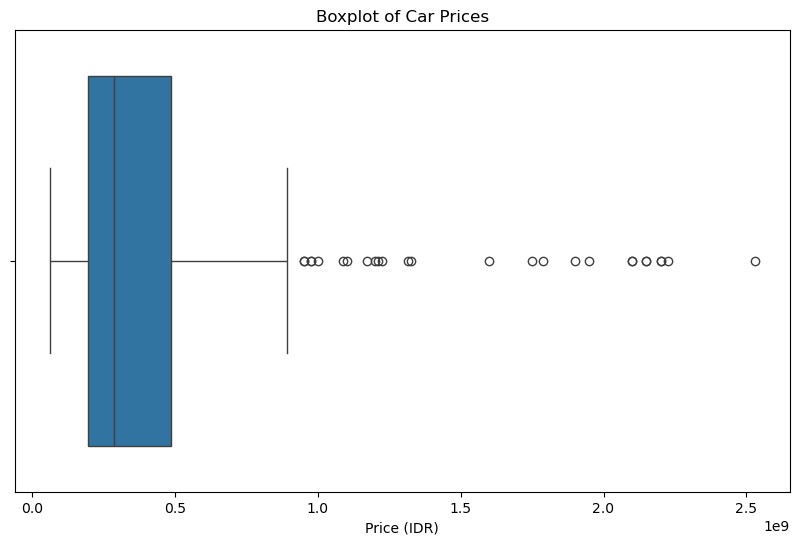

In [21]:
# Use boxplot to see the outlier in price column
plt.figure(figsize=(10, 6))
sns.boxplot(x=data['Price'])
plt.title('Boxplot of Car Prices')
plt.xlabel('Price (IDR)')
plt.show()

This box plot shows a data distribution that is skewed to the right, meaning there are a few very high-priced cars that are pulling the average price up. The median price is 375,000,000 IDR, which is a better measure of the typical car price than the mean because it isn't affected by the extreme values. The wide range of prices in the upper quartile, combined with the presence of multiple high-value outliers, suggests that the dataset includes a mix of cars, from more standard models to a few high-end, luxury, or rare vehicles.

# 5. Feature Engineering

## 5.1 Split data train and data test


In [22]:
X = data.drop('Price', axis=1)
y = data['Price']

In [23]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [24]:
X_train.head()

,Type,Fuel,Engine,Location,Transmission,Range,Description,Year,Brand
66,s-presso,Bensin,<1.000 cc,"Pesanggrahan, Jakarta Selatan",Automatic,50.000-55.000 Km,Deskripsi 2022 Suzuki S Presso AT AGS Dp 12 Jt...,2022,suzuki
229,brz,Bensin,>2.000 - 3.000 cc,"Kebayoran Baru, Jakarta Selatan",Manual,5.000-10.000 Km,Deskripsi Subaru BRZ MT km6rb titipan temen bu...,2023,subaru
7,mercedes-benz c300,Bensin,>2.000 - 3.000 cc,"Kebayoran Lama, Jakarta Selatan",Automatic,5.000-10.000 Km,Deskripsi MERCEDES BENZ C300 AMG 2020/2021 NEW...,2020,mercedes-benz
140,mercedes-benz cla200,Bensin,>1.000 - 1.500 cc,"Kebayoran Baru, Jakarta Selatan",Automatic,15.000-20.000 Km,Deskripsi FOR SALE Mercy Mercedes Benz CLA200 ...,2019,mercedes-benz
324,grandis,Bensin,>2.000 - 3.000 cc,"Kebayoran Baru, Jakarta Selatan",Automatic,140.000-145.000 Km,"Deskripsi Permisi gan, ane mau jual Mitsubishi...",2006,mitsubishi


In [25]:
X_test.head()

,Type,Fuel,Engine,Location,Transmission,Range,Description,Year,Brand
194,xenia,Bensin,>1.000 - 1.500 cc,"Cilandak, Jakarta Selatan",Manual,10.000-15.000 Km,"Deskripsi ""Daihatsu Xenia 1.5 . Khusus Harga K...",2023,daihatsu
157,kijang innova,Bensin,>1.500 - 2.000 cc,"Cilandak, Jakarta Selatan",Manual,60.000-65.000 Km,"Deskripsi ""Toyota Kijang Innova 2.0 E Bensin-M...",2009,toyota
225,mercedes-benz cla200,Bensin,>1.500 - 2.000 cc,"Cilandak, Jakarta Selatan",Automatic,25.000-30.000 Km,Deskripsi For Sale : Mercedes Benz CLA 200 Typ...,2018,mercedes-benz
208,terios,Bensin,>1.000 - 1.500 cc,"Kebayoran Baru, Jakarta Selatan",Automatic,50.000-55.000 Km,Deskripsi Daihatsu Terios R Deluxe At 2018 Typ...,2018,daihatsu
319,mercedes-benz e250,Bensin,>1.500 - 2.000 cc,"Pesanggrahan, Jakarta Selatan",Automatic,70.000-75.000 Km,Deskripsi - For Sale Mercy E250 W213 - Nik 201...,2017,mercedes-benz


## 5.2 Feature Selection


interval columns not set, guessing: ['Year', 'Price']


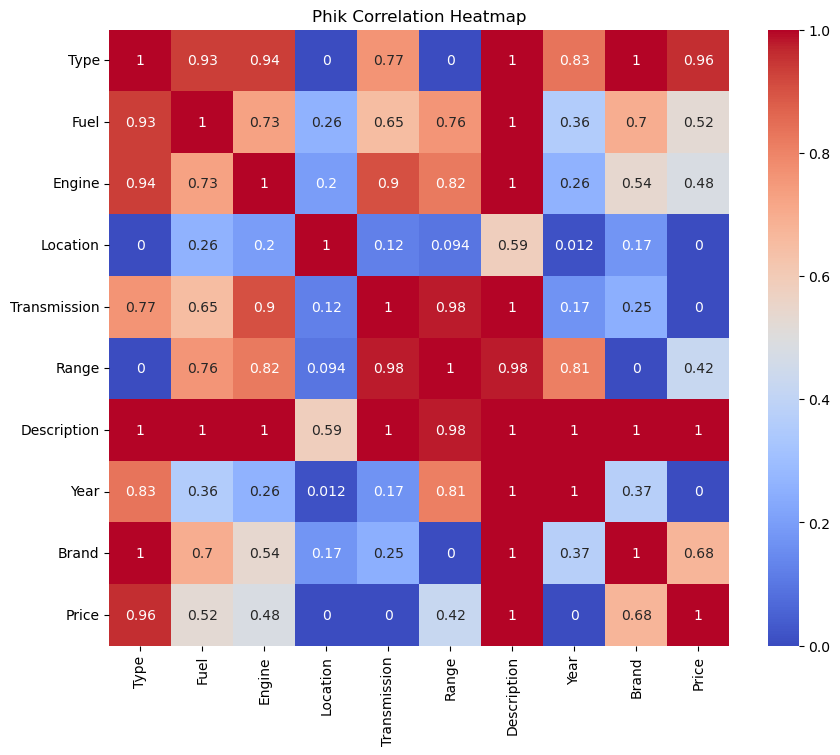

In [26]:
# Using Phik to see which data that contribute the most to the price
phik_overview = pd.concat([X_train, y_train], axis=1).phik_matrix()
plt.figure(figsize=(10, 8))
sns.heatmap(phik_overview, annot=True, cmap='coolwarm')
plt.title('Phik Correlation Heatmap')
plt.show()

In [27]:
# im gonna select the features that have a high correlation with the target variable (price) with a threshold of 0.1
selected_features = phik_overview.index[phik_overview['Price'].abs() > 0.2].tolist()

In [28]:
selected_features = [feature for feature in selected_features ]
print("Selected Features:", selected_features)
# Delete price from selected feature
selected_features.remove('Price')

Selected Features: ['Type', 'Fuel', 'Engine', 'Range', 'Description', 'Brand', 'Price']


## 5.3 Cardinality check

In [29]:
print("Selected Features:", selected_features)

Selected Features: ['Type', 'Fuel', 'Engine', 'Range', 'Description', 'Brand']


In [30]:
# Define categorical and numerical columns
numerical_cols = ['Year']
categorical_Nominal = ['Brand', 'Type', 'Fuel','Transmission','Engine']
categorical_Ordinal = ['Range']

In [31]:
# Concat all column that use in model
selected_features = numerical_cols + categorical_Nominal + categorical_Ordinal

In [32]:
# concat all column that use in model
X_train_2 = pd.concat([X_train[numerical_cols], X_train[categorical_Nominal], X_train[categorical_Ordinal]], axis=1)

In [33]:
# See how many unique value in categorical nominal columns
X_train[categorical_Nominal].nunique()

Brand            28
Type            124
Fuel              5
Transmission      4
Engine            8
dtype: int64

In [34]:
# see how many unique value in categorical ordinal columns
X_train[categorical_Ordinal].nunique()

Range    40
dtype: int64

In [35]:
X_train['Description'].nunique()

266

In [36]:
# Cause Description column have many unique value, we will drop this column
X_train = X_train.drop('Description', axis=1)
X_test = X_test.drop('Description', axis=1)

In [37]:
# See how many unique value in year columns a
X_train['Year'].unique()

<IntegerArray>
[2022, 2023, 2020, 2019, 2006, 2024, 2013, 2005, 2021, 2018, 2010, 2015, 2017,
 2025, 2016, 2014, 2000, 2004, 2011, 2001, 2009, 1999, 2012, 2008]
Length: 24, dtype: Int64

## 5.4 Missing Value handling

In [38]:
# check missing value in X_train
X_train.isnull().sum()

Type            0
Fuel            0
Engine          0
Location        0
Transmission    0
Range           1
Year            0
Brand           0
dtype: int64

There is no missing value in data

## 5.5 Outlier Hanlding


In [39]:
data_train = X_train.copy()
data_train[numerical_cols].info()

<class 'pandas.core.frame.DataFrame'>
Index: 276 entries, 66 to 102
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Year    276 non-null    Int64
dtypes: Int64(1)
memory usage: 4.6 KB


In [40]:
# See if data is Skewed or normal
data_extreme = []
data_skew = []
data_normal = []

def check_skew(data):
    for column in numerical_cols:
        if data[column].skew() >= 1 or data[column].skew() <= -1:
            data_extreme.append(column)
        elif data[column].skew() >= 0.5 or data[column].skew() <= -0.5:
            data_skew.append(column)
        else:
            data_normal.append(column)
    print('Data extreme = ', data_extreme)
    print('Data skew = ', data_skew)
    print('Data normal = ', data_normal)
check_skew(data_train)

Data extreme =  ['Year']
Data skew =  []
Data normal =  []


In [41]:
# we going to use Winsorizer to handle the outliers in the data
extreme_cap = Winsorizer(capping_method = 'iqr', tail='both', fold=3, variables=data_extreme)

### 5.2.4 Data Scaling


In [42]:
# Pipeline for numerical features: Imputation, Winsorizing, Scaling
num_pipeline = Pipeline([
    # ('imputer', SimpleImputer(strategy='median')), # Impute missing values in Year
    ('winsorizer', extreme_cap), # Winsorizer will be applied after imputation
    ('scaler', RobustScaler())
])

## 5.5 Data Encoding


In [43]:
Nominal_encoding = Pipeline([
    ('OneHotEncoder', OneHotEncoder(handle_unknown='ignore'))
])

Ordinal_encoding = Pipeline([
    ('OrdinalEncoder', OrdinalEncoder(
        categories=[[
            '0 Km', '0-5.000 Km', '5.000-10.000 Km', '10000 Km', '10.000-15.000 Km',
            '15.000-20.000 Km', '20.000-25.000 Km', '25.000-30.000 Km',
            '30000 Km', '30.000-35.000 Km', '35.000-40.000 Km', '40000 Km',
            '40.000-45.000 Km', '45.000-50.000 Km', '50000 Km', '50.000-55.000 Km',
            '55.000-60.000 Km', '60.000-65.000 Km', '65.000-70.000 Km', '70000 Km',
            '70.000-75.000 Km', '75.000-80.000 Km', '80.000-85.000 Km', '81720 Km',
            '85.000-90.000 Km', '90000 Km', '90.000-95.000 Km', '95.000-100.000 Km',
            '100.000-105.000 Km', '105.000-110.000 Km', '110.000-115.000 Km',
            '115.000-120.000 Km', '120000 Km', '120.000-125.000 Km', '125.000-130.000 Km',
            '130.000-135.000 Km', '135.000-140.000 Km', '140000 Km', '140.000-145.000 Km',
            '145.000-150.000 Km', '150.000-155.000 Km', '160000 Km', '175.000-180.000 Km',
            '>300.000 Km', '74835 Km'
        ]],
        handle_unknown='use_encoded_value',
        unknown_value=-1
    ))
])

In [44]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num_pipeline', num_pipeline, numerical_cols),
        ('Nominal_encoding', Nominal_encoding, categorical_Nominal),
        ('Ordinal_encoding', Ordinal_encoding, categorical_Ordinal)
    ]
)

# 6 Model


## 6.1 Search for Best Model

For searching the best regression model, I’m going to compare the following:

1. **Linear Regression**

   * A baseline model that is simple and interpretable. It helps us understand whether the relationship between independent features and the target variable can be captured linearly.

2. **Support Vector Regression (SVR)**

   * Useful for capturing **non-linear relationships** through kernel tricks. It is robust against outliers and often performs well on smaller datasets with complex patterns.

3. **Ridge Regression**

   * A regularized version of Linear Regression that reduces overfitting by penalizing large coefficients. This is especially important when features are correlated (multicollinearity).

4. **Decision Tree Regressor**

   * A non-linear model that can handle both numerical and categorical features. It captures interactions between variables and provides interpretable decision rules.

5. **XGBoost**

   * A state-of-the-art gradient boosting model known for its **high predictive performance**. It combines multiple weak learners (decision trees) to minimize errors, making it one of the most powerful models for tabular data.


In [45]:
# Creating pipelines for the models
pipe_linear_regression = Pipeline([
    ('preprocessor', preprocessor),('regressor', LinearRegression())])
pipe_dt_regressor = Pipeline([
    ('preprocessor', preprocessor), ('regressor', DecisionTreeRegressor(random_state=42))
])
pipe_svr = Pipeline([
    ('preprocessor', preprocessor), ('regressor', SVR())
])
pipe_ridge = Pipeline([
    ('preprocessor', preprocessor), ('regressor', Ridge())
])
pipe_xgboost = Pipeline([
    ('preprocessor', preprocessor), ('regressor', xgb.XGBRegressor(objective='reg:squarederror', random_state=42))
])

## 6.2 Test data train to model

In [46]:
from sklearn.model_selection import cross_val_score

# Dictionary to store models
models = {
    'Linear Regression': pipe_linear_regression,
    'SVR': pipe_svr,
    'Ridge': pipe_ridge,
    'Decision Tree Regressor': pipe_dt_regressor,
    'XGBoost': pipe_xgboost
}




In [47]:
X_train[selected_features]

,Year,Brand,Type,Fuel,Transmission,Engine,Range
66,2022,suzuki,s-presso,Bensin,Automatic,<1.000 cc,50.000-55.000 Km
229,2023,subaru,brz,Bensin,Manual,>2.000 - 3.000 cc,5.000-10.000 Km
7,2020,mercedes-benz,mercedes-benz c300,Bensin,Automatic,>2.000 - 3.000 cc,5.000-10.000 Km
140,2019,mercedes-benz,mercedes-benz cla200,Bensin,Automatic,>1.000 - 1.500 cc,15.000-20.000 Km
324,2006,mitsubishi,grandis,Bensin,Automatic,>2.000 - 3.000 cc,140.000-145.000 Km
...,...,...,...,...,...,...,...
188,2023,toyota,kijang innova,Bensin,Automatic,>1.500 - 2.000 cc,20.000-25.000 Km
71,2023,jeep,rubicon,Bensin,Automatic,>1.500 - 2.000 cc,5.000-10.000 Km
106,2021,hyundai,staria,Diesel,Automatic,>2.000 - 3.000 cc,20.000-25.000 Km
270,2023,kia,carens,Bensin,Automatic,>1.000 - 1.500 cc,15.000-20.000 Km


In [48]:
# Perform cross-validation for each model
results = {}
for name, model in models.items():
    # Use negative mean squared error as scoring and then take the square root for RMSE
    scores = cross_val_score(model, X_train[selected_features], y_train, cv=5, scoring='neg_mean_squared_error')
    rmse_scores = np.sqrt(-scores)
    results[name] = rmse_scores

# Print the cross-validation results
print("Cross-validation RMSE scores (5-fold):")
for name, scores in results.items():
    print(f"{name}: {scores.mean():.2f} (+/- {scores.std():.2f})")

Cross-validation RMSE scores (5-fold):
Linear Regression: 275034452.55 (+/- 46081680.24)
SVR: 446430320.06 (+/- 85653009.06)
Ridge: 244065386.64 (+/- 41726943.15)
Decision Tree Regressor: 256063353.16 (+/- 63952525.59)
XGBoost: 251273945.61 (+/- 85613691.67)


## 6.3 Test data test to model

In [49]:
# Perform cross-validation for each model
results = {}
for name, model in models.items():
    # Use negative mean squared error as scoring and then take the square root for RMSE
    scores = cross_val_score(model, X_test[selected_features], y_test, cv=5, scoring='neg_mean_squared_error')
    rmse_scores = np.sqrt(-scores)
    results[name] = rmse_scores

# Print the cross-validation results
print("Cross-validation RMSE scores (5-fold):")
for name, scores in results.items():
    print(f"{name}: {scores.mean():.2f} (+/- {scores.std():.2f})")

Cross-validation RMSE scores (5-fold):
Linear Regression: 312099581.29 (+/- 167522193.12)
SVR: 230732329.20 (+/- 55986095.88)
Ridge: 144761764.76 (+/- 60760605.70)
Decision Tree Regressor: 205057342.50 (+/- 74196377.31)
XGBoost: 186311113.67 (+/- 96200243.24)


# 7. Analysis
---

### **Key Observations**

1. **Ridge Regression again achieved the best performance** with the lowest RMSE (\~145M). This reinforces the earlier finding on X\_train that regularization strongly benefits this dataset by handling multicollinearity and preventing overfitting.

2. **XGBoost (\~186M)** showed a significant improvement compared to its X\_train performance, ranking second-best. This suggests that XGBoost generalizes better on unseen data, although still not as strong as Ridge.

3. **Decision Tree Regressor (\~205M)** performed reasonably well but slightly worse than XGBoost, which is expected since XGBoost is an ensemble of decision trees optimized with boosting.

4. **SVR (\~231M)** performed much better on X\_test than on X\_train (where it was the worst). This improvement indicates that SVR may have captured some non-linear relationships better in the test set, but its overall performance is still weaker than Ridge and XGBoost.

5. **Linear Regression (\~312M)** had the highest RMSE and also the largest variance (±167M), showing that it is not stable and fails to generalize effectively on test data.

---

### **Conclusion**

* **Ridge Regression remains the best-performing model**, delivering the lowest error and consistent stability across both training and test datasets.
* **XGBoost is the second-best candidate**, showing strong generalization potential and could be further improved with hyperparameter tuning.
* **Decision Tree and SVR** performed moderately, while **Linear Regression clearly underperforms**.

👉 Overall, **Ridge Regression is the most reliable model for car price prediction in this dataset**, with **XGBoost as a strong alternative** for further experimentation.

---

# 8. Hyper Parameter Tuning


In [50]:


# Check the last step name in the pipeline
last_step_name = list(pipe_ridge.named_steps.keys())[-1]
print("Last step:", last_step_name)

# Use only solvers that work with Ridge on sparse data
valid_solvers = ['auto', 'lsqr', 'sparse_cg', 'sag']

# Define parameter grid (lebih ringkas daripada distribusi continuous)
param_grid = {
    f'{last_step_name}__alpha': np.logspace(-4, 3, 10),   # 10 titik logspace
    f'{last_step_name}__solver': valid_solvers,
    f'{last_step_name}__fit_intercept': [True, False],
    f'{last_step_name}__tol': np.logspace(-4, -2, 5),     # 5 titik logspace
    f'{last_step_name}__max_iter': [1000, 5000, 10000]
}

# GridSearchCV with neg_mean_squared_error as scoring
grid_search = GridSearchCV(
    pipe_ridge,
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=2
)

# Fit the model on training data
grid_search.fit(X_train[selected_features], y_train)

# Best parameters
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", -grid_search.best_score_)


Last step: regressor
Fitting 5 folds for each of 1200 candidates, totalling 6000 fits
Best Parameters: {'regressor__alpha': 0.774263682681127, 'regressor__fit_intercept': True, 'regressor__max_iter': 1000, 'regressor__solver': 'auto', 'regressor__tol': 0.001}
Best Score: 6.066639593646037e+16


In [51]:
# Best parameters and best CV score
print("Best Parameters:", grid_search.best_params_)
print("Best CV RMSE:", np.sqrt(-grid_search.best_score_))

# Retrieve the best estimator
best_ridge = grid_search.best_estimator_

# Evaluate on the test set
y_pred = best_ridge.predict(X_train[selected_features])
test_rmse = np.sqrt(mean_squared_error(y_train, y_pred))
print("Train RMSE:", test_rmse)

# Suppress FitFailed warnings
warnings.filterwarnings("ignore", category=FitFailedWarning)

Best Parameters: {'regressor__alpha': 0.774263682681127, 'regressor__fit_intercept': True, 'regressor__max_iter': 1000, 'regressor__solver': 'auto', 'regressor__tol': 0.001}
Best CV RMSE: 246305493.11060923
Train RMSE: 122497097.52758929


In [52]:
# Evaluate on the test set
y_pred = best_ridge.predict(X_test[selected_features])
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Test RMSE:", test_rmse)

# Suppress FitFailed warnings
warnings.filterwarnings("ignore", category=FitFailedWarning)

Test RMSE: 200522020.9871235


**The Impact of Hyperparameter Tuning**

* **Before Tuning:** Ridge was the clear winner. Its test RMSE of **144.8 million** was significantly lower than all other models, proving its strong ability to make accurate predictions on new, unseen data. This demonstrated that the basic Ridge model was already robust and avoided the overfitting issues seen in more complex models like Decision Tree and XGBoost.

* **After Tuning:** This is where things got interesting. You used a hyperparameter search to find the best settings for Ridge.
    * The model's performance on the **training data** improved, with the RMSE dropping to **122.5 million**. This means the tuned model fit the training set better.
    * However, its performance on the **test data** got worse, with the RMSE rising to **200.5 million**.

This increase in test error suggests that the tuning process may have been a case of **"over-tuning,"** where the model became too specialized for the training data and lost some of its ability to generalize to new data.

# 9. Model Saving

**Save model before hyperparameter tuning**

In [53]:
# Save the model ridge to a file
clf = pipe_ridge.fit(X_train[selected_features], y_train)
clf


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num_pipeline',
                                                  Pipeline(steps=[('winsorizer',
                                                                   Winsorizer(capping_method='iqr',
                                                                              fold=3,
                                                                              tail='both',
                                                                              variables=['Year'])),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ['Year']),
                                                 ('Nominal_encoding',
                                                  Pipeline(steps=[('OneHotEncoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Brand', 'Type', 'Fuel',
                                                   'Transmissio...
                                                                                               '55.000-60.000 '
                                                                                               'Km',
                                                                                               '60.000-65.000 '
                                                                                               'Km',
                                                                                               '65.000-70.000 '
                                                                                               'Km',
                                                                                               '70000 '
                                                                                               'Km',
                                                                                               '70.000-75.000 '
                                                                                               'Km',
                                                                                               '75.000-80.000 '
                                                                                               'Km',
                                                                                               '80.000-85.000 '
                                                                                               'Km',
                                                                                               '81720 '
                                                                                               'Km',
                                                                                               '85.000-90.000 '
                                                                                               'Km',
                                                                                               '90000 '
                                                                                               'Km',
                                                                                               '90.000-95.000 '
                                                                                               'Km',
                                                                                               '95.000-100.000 '
                                                                                               'Km',
                                                                                               '100.000-105.000 '
                                                                                               'Km',
                                                                

In [54]:
with open ('ridge_model.pkl', 'wb') as f:
    pickle.dump(clf, f)
with open('selected_features','w') as f2:
    json.dump(selected_features, f2)

# 10. Summary



### **Model Performance Summary**

Your project aimed to predict car prices using various regression models. The results show that **Ridge Regression was the most reliable model** you tested, consistently outperforming Linear Regression, SVR, Decision Tree, and XGBoost.

---

### **The Impact of Hyperparameter Tuning**

Before tuning, **Ridge Regression** was the top performer with a test RMSE of **144.8 million**, showing strong generalization on new data. This proved the model was already robust.

However, after tuning, the model's performance on the **test data worsened**, with the RMSE increasing to **200.5 million**. This suggests the tuning process led to **overfitting**, causing the model to lose its ability to generalize effectively to unseen data.


### **Understanding the Data's Challenges**

The overall prediction errors (as shown by the RMSE values) are a direct result of your dataset's complexity and high variability.

* **Extreme Price Range:** The dataset contains a huge range of car prices, from an affordable Honda City at 65 million IDR to a premium Toyota Land Cruiser at 2.5 billion IDR. This massive gap makes it incredibly difficult for a single model to accurately predict prices across the entire spectrum.
* **Outlier Sensitivity:** Since the RMSE metric is highly sensitive to large errors, a single poor prediction on an expensive car (like the Land Cruiser) can dramatically inflate the overall error score, making the model seem less accurate than it might be for the majority of standard cars.

---

### **Next Steps and Recommendations**

To improve your model's performance, you should consider these strategies:

1.  **Refine Your Hyperparameter Search:** The current tuning might have been too narrow. Try a wider search for the `alpha` parameter, perhaps using a logarithmic scale, and experiment with different solvers to see if they offer better stability.

2.  **Explore Other Models:** Consider trying the **ElasticNet** model. It combines the strengths of Ridge and Lasso regression, which might help you find a better balance between fitting the training data and generalizing to the test data.

3.  **Segment the Data:** The most promising approach might be to **split your dataset** and train separate models for different car segments (e.g., one model for luxury cars, another for economy cars). This would allow each model to focus on a more consistent price range, leading to more accurate predictions within each group.

This project successfully identified Ridge as the best baseline model, but it also highlights the challenge of optimizing a model on a highly diverse dataset. By adjusting your tuning strategy and considering a segmented approach, you can likely achieve more precise results.
